In [6]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

In [2]:
vgg = models.vgg19(models.VGG19_Weights.DEFAULT)
for param in vgg.parameters():
    param.requires_grad_(False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 73.6MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [12]:
def load_image(img_path, max_size=400, shape=None):

    if 'http' in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')

    size = max_size

    transform = transforms.Compose([transforms.Resize((size,size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406),
                                                         (0.229, 0.224, 0.225))])

    image = transform(image)

    image = image[:3,:,:].unsqueeze(0)

    return image

In [13]:
content = load_image('/content/Summer 2022.jpg').to(device)
style = load_image("https://dafb3cv85j5xj.cloudfront.net/blog/wp-content/uploads/2017/06/Screen-Shot-2017-06-12-at-10.25.04-AM.png").to(device)

In [14]:
def im_convert(tensor):
    #for plotting tensor images
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

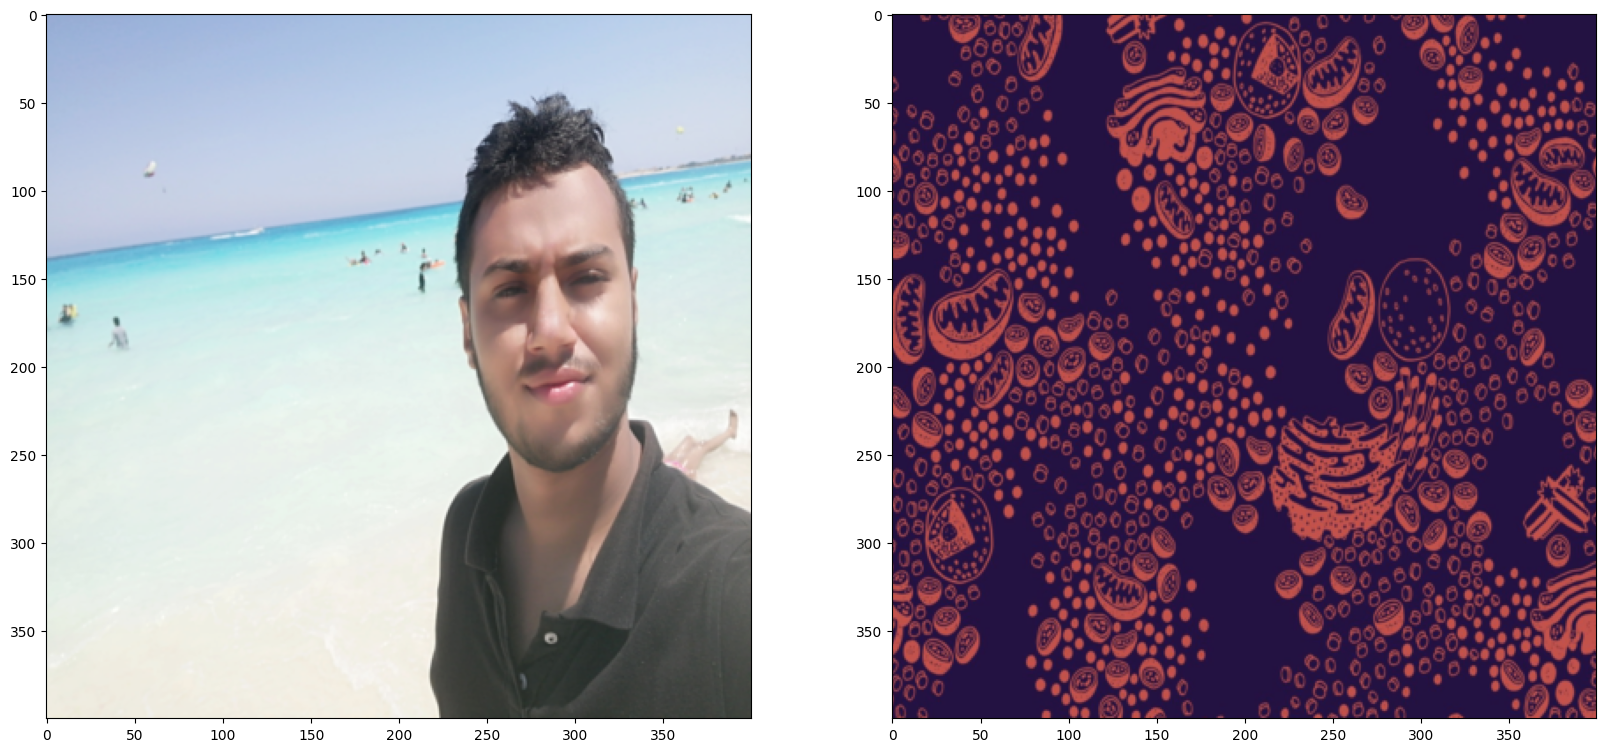

In [15]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content));
ax2.imshow(im_convert(style));

In [16]:
#checking loades images sizes after tranforming pipeline
content.shape, style.shape

(torch.Size([1, 3, 400, 400]), torch.Size([1, 3, 400, 400]))

In [17]:
def get_features(image, model, layers=None):
    #getting the output for each layer of the inputted-image
    #after each pass through the hidden convolutional layer

    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}

    features = {}

    x = image.reshape(image.shape)
    for _, layer in model.named_children():
        for layer_ in layer.modules():
            for name, _layer_ in layer_.named_children():
                x = _layer_(x)

                if name in layers and layers[name] not in features:
                    features[layers[name]] = x.clone()

                if list(layers.values()) == list(features.keys()):
                    return features

    return features

In [18]:
def gram_matrix(tensor):
    #calculation of the gram matrix at each layer
    #used in calculation of the style loss at each hidden convolutional layer
    batch_size, d, h, w = tensor.shape

    gram = tensor.view(batch_size*d, h*w)

    gram = torch.mm(gram, gram.t())

    return gram

In [21]:
content_features = get_features(content, vgg) #content imagefeatures
style_features = get_features(style, vgg)   #style image features

style_grams={layer:gram_matrix(style_features[layer]) for layer in style_features} #style image gram matrices
                                                                                   #at each hidden convolutional layer
target = content.clone().requires_grad_(True).to(device)    #target image that its values will be updated

In [22]:
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e9  # beta

Total loss:  2024718073856.0


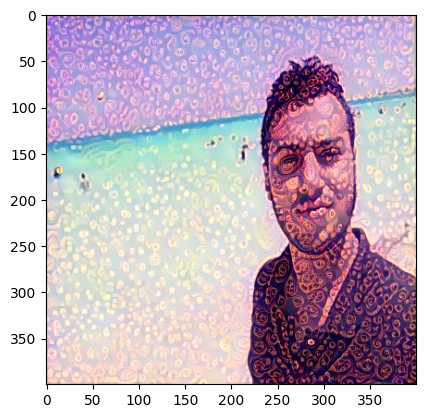

Total loss:  1295582625792.0


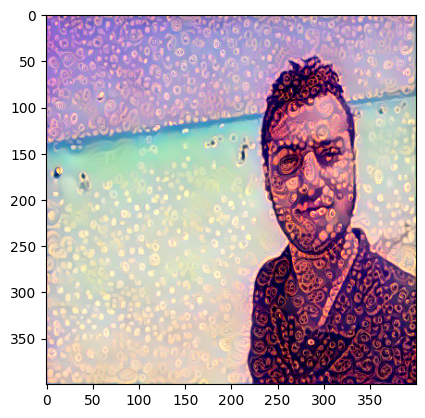

Total loss:  959433867264.0


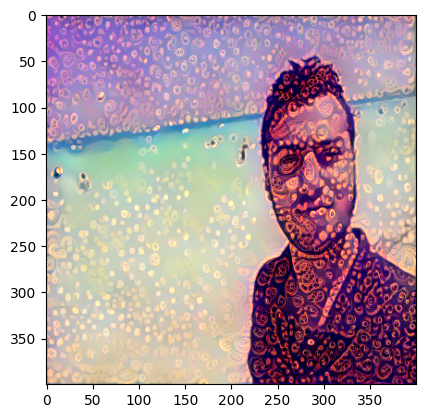

Total loss:  754860752896.0


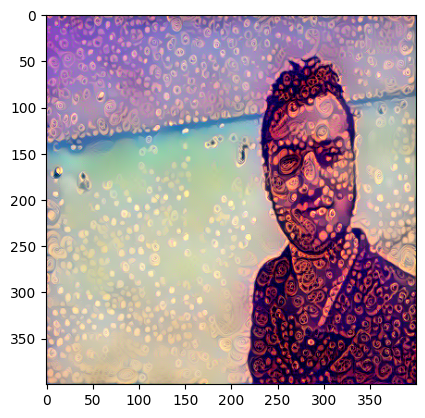

Total loss:  614303137792.0


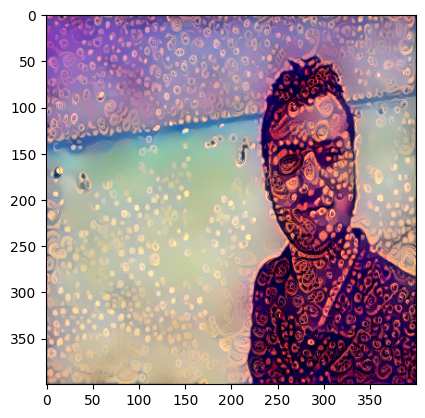

Total loss:  510703566848.0


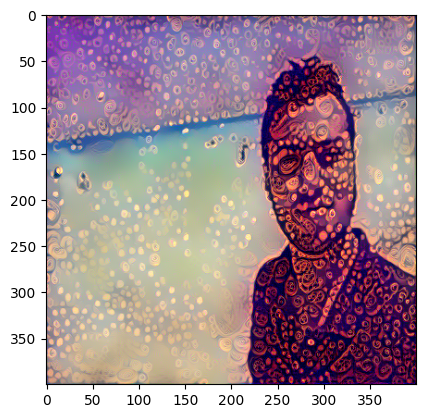

Total loss:  430814625792.0


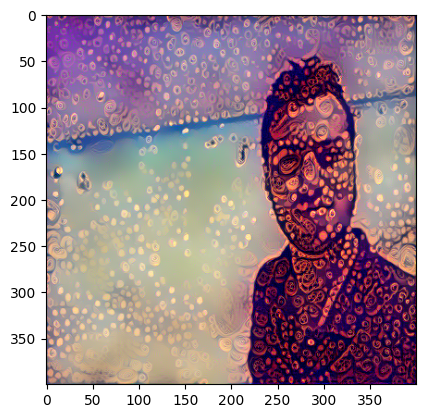

Total loss:  366722056192.0


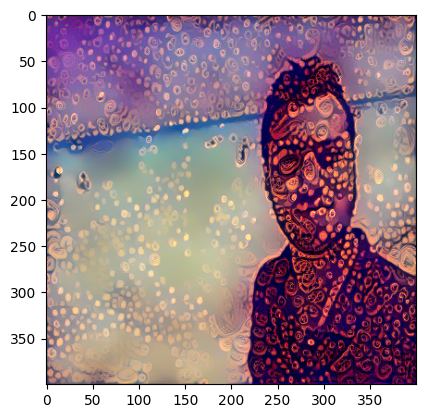

Total loss:  314697383936.0


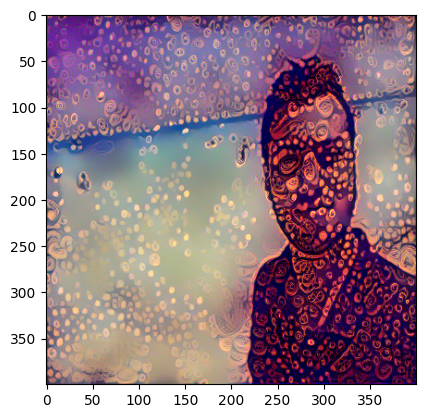

Total loss:  271570763776.0


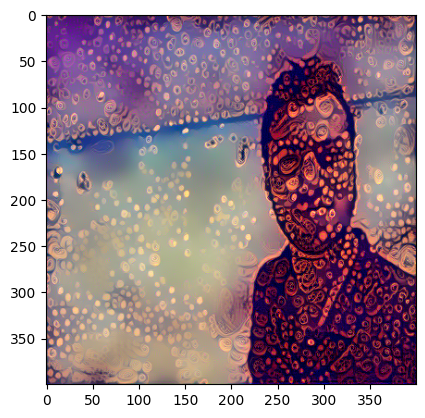

In [33]:
show_every = 500
epochs = 5000
optimizer = optim.Adam([target], lr=0.002)

for i in range(1,epochs+1):
    optimizer.zero_grad()

    target_features = get_features(target, vgg)

    content_loss = torch.mean(((content_features['conv4_2'] - target_features['conv4_2'])**2))

    style_loss = 0

    for layer in style_weights:
        target_gram = gram_matrix(target_features[layer])
        _, depth, height, width = target_features[layer].shape
        style_gram = style_grams[layer]

        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (depth * height * width)

    total_loss = content_weight*content_loss + style_weight*style_loss
    total_loss.backward()
    optimizer.step()

    if  i % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

In [34]:
batch_size, d, h, w = style.shape
batch_size, d, h, w

(1, 3, 400, 400)